In [1]:
! source activate cs_7641_group_proj

zsh:source:1: no such file or directory: activate


In [2]:
! conda list

# packages in environment at /Users/marcsilverman/anaconda3/envs/cs_7641_group_proj:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
appnope                   0.1.3           py312hecd8cb5_1001  
asttokens                 2.0.5              pyhd3eb1b0_0  
blas                      1.0                         mkl  
brotli-python             1.1.0           py312heafc425_1    conda-forge
bzip2                     1.0.8                h6c40b1e_5  
c-ares                    1.19.1               h6c40b1e_0  
ca-certificates           2024.2.2             h8857fd0_0    conda-forge
cached-property           1.5.2                      py_0  
cached_property           1.5.2              pyha770c72_1    conda-forge
certifi                   2024.2.2           pyhd8ed1ab_0    conda-forge
charset-normalizer        3.3.2              pyhd8ed1ab_0    conda-forge
cms-md5                   1.0.0                h0d85af4_1 

In [3]:
# %pip install --upgrade pyarrow
# %pip install --upgrade polars

In [3]:
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Download the snappy headers data from colab

In [4]:
! python3 ../snaps.py

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
/Users/marcsilverman/anaconda3/envs/cs_7641_group_proj/lib/python3.12/site-packages/polars/_cpu_check.py:232: RuntimeWarning: Missing required CPU features.

The following required CPU features were not detected:
    avx, fma
Continuing to use this version of Polars on this processor will likely result in a crash.
Install the `polars-lts-cpu` package instead of `polars` to run Polars with better compatibility.

Hint: If you are on an Apple ARM machine (e.g. M1) this is likely due to running Pyth

In [5]:
print(f"Pandas version: {pd.__version__}")

# Print Python version
import sys
print(f"Python version: {sys.version}")

Pandas version: 2.2.1
Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]


In [6]:
#table = pd.read_table("../raw_data/all_header_file_data.parquet.snappy")

    # Convert the decompressed Parquet file to a Polars DataFrame
df = pd.read_parquet("../raw_data/all_header_file_data.parquet.snappy")

In [7]:
df.shape
df.head

<bound method NDFrame.head of       patient_id   age     sex           snomed_concept_name
0        JS24996  66.0  Female             Sinus bradycardia
1        JS24966  46.0    Male                 ST Depression
2        JS24966  46.0    Male               Inverted T wave
3        JS24966  46.0    Male             Sinus bradycardia
4        JS24966  46.0    Male  Left ventricular hypertrophy
...          ...   ...     ...                           ...
86387    JS10474  65.0    Male  Supraventricular tachycardia
86388    JS10439  87.0  Female     Right bundle branch block
86389    JS10439  87.0  Female  Supraventricular tachycardia
86390    JS10422  52.0  Female  Supraventricular tachycardia
86391    JS10486  59.0  Female  Supraventricular tachycardia

[86392 rows x 4 columns]>

In [8]:
missing_age = df['age'].isnull().sum()
missing_sex = df['sex'].isnull().sum()
missing_snomed_concept_name = df['snomed_concept_name'].isnull().sum()

# Print missing value counts
print("missing age:", missing_age)
print("missing gender:", missing_sex)
print("missing snowmed:", missing_snomed_concept_name)
print("original df shape:", df.shape)

# Drop rows with null values
df_clean = df.dropna()

# Print the shape of the cleaned DataFrame
print("cleaned df shape:", df_clean.shape)

missing age: 149
missing gender: 0
missing snowmed: 0
original df shape: (86392, 4)
cleaned df shape: (86243, 4)


In [9]:
unique_values_count = df_clean['snomed_concept_name'].nunique()

# Print the count of unique values
print("unique snowmed concepts:", unique_values_count)


unique snowmed concepts: 77


One hot encode snowmed concepts and sex

In [10]:
print(type(df_clean))

<class 'pandas.core.frame.DataFrame'>


In [11]:
! pip install kmodes

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder



In [27]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame df_clean with 'age', 'sex', and 'snomed_concept_name'

# Create a copy to avoid modifying the original DataFrame
df_encoded = df_clean.copy()

# Use LabelEncoder for 'sex'
label_encoder_sex = LabelEncoder()
df_encoded['sex'] = label_encoder_sex.fit_transform(df_encoded['sex'])

# Use LabelEncoder for 'snomed_concept_name'
label_encoder_snomed = LabelEncoder()
df_encoded['snomed_concept_code'] = label_encoder_snomed.fit_transform(df_encoded['snomed_concept_name'])

# Define categorical and numerical columns
categorical_columns = ['sex']
numerical_columns = ['age']

# Define a function to perform clustering within each group
def cluster_within_group(group):
    # Get unique values of 'sex' and 'age' within the group
    unique_sex = group['sex'].unique()
    unique_age = group['age'].unique()
    
    # Initialize initial centroids
    initial_centroids = []
    for sex_val in unique_sex:
        for age_val in unique_age:
            initial_centroids.append([age_val, sex_val])
    
    # Convert initial centroids to array
    initial_centroids = np.array(initial_centroids)
    
    # Perform clustering
    kproto = KPrototypes(n_clusters=len(initial_centroids), init=initial_centroids, verbose=2)
    group_data = group[numerical_columns + categorical_columns].values
    clusters = kproto.fit_predict(group_data, categorical=[0])  # Categorical index for 'sex'
    group['cluster'] = clusters
    return group

# Apply clustering within each group of 'snomed_concept_code'
df_clustered = df_encoded.groupby('snomed_concept_code').apply(cluster_within_group).reset_index(drop=True)

# Display DataFrame with Cluster Labels
print("DataFrame with Cluster Labels:")
print(df_clustered)


Initialization method and algorithm are deterministic. Setting n_init to 1.


AssertionError: Cannot have more clusters (30) than data points (16).

In [ ]:
!pip install matplotlib
!pip install seaborn                                                    

In [14]:
import matplotlib as plt
import seaborn as sns

AttributeError: module 'matplotlib' has no attribute 'show'

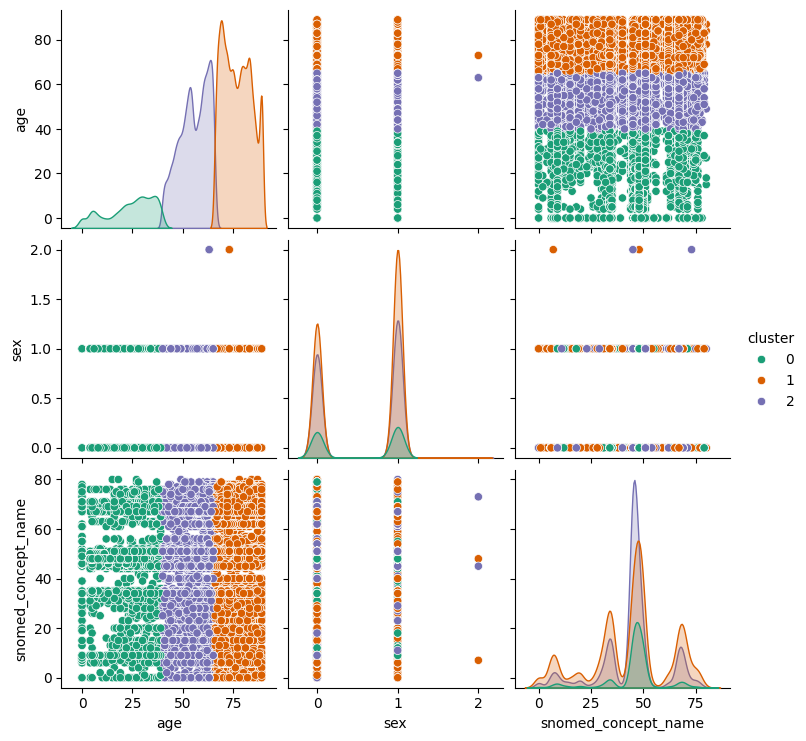

In [16]:
sns.pairplot(df_encoded, hue='cluster', palette='Dark2')
plt.show()